### Rust density matrix benchmark using Cleps

In [1]:
!pip install matplotlib
from pycleps.cleps_ssh_wrapper import ClepsSSHWrapper
from scp import SCPClient
from pathlib import Path
import re

### Fetch results

In [9]:
def get_nqubits(p: Path):
    return int(re.search(r'_(\d+)\.log$', str(p)).group(1))

def get_times(out: str) -> list[str, str]:
    return re.findall(r'function calls .*? in ([\d.]+) seconds', out)

# use getfo to get file content as file object
def extract_and_get_results(repo_path, jobId):
    wrapper = ClepsSSHWrapper(username="bguichar", wd='.') # Connect to cleps
    fetched = wrapper.fetch(jobId, repo_path)
    times = dict()

    for (path, content) in fetched: # Put the outputs in a dictionary of the form 'nqubits': { time_rs, time_np }
        n = get_nqubits(path)
        t = get_times(content)
        if len(t) != 2:  # The job has not finished yet. We are looking for only two time values.
            continue
        times.update({ n: { "np": t[0], "rs": t[1] } })

    return times

### Simulation ran with
`pycleps --repo graphix-fork/ --branch dm-simu-rust --script 'python graphix-fork/benchmarks/dm.py' --env environment.yml --setup 'pip install .' --cpt 64 --array=2-11 --time 5:00:00`

In [11]:
repo_path = Path("graphix-fork") # Remote repo path
jobId = "3958437"
times = extract_and_get_results(repo_path, jobId)

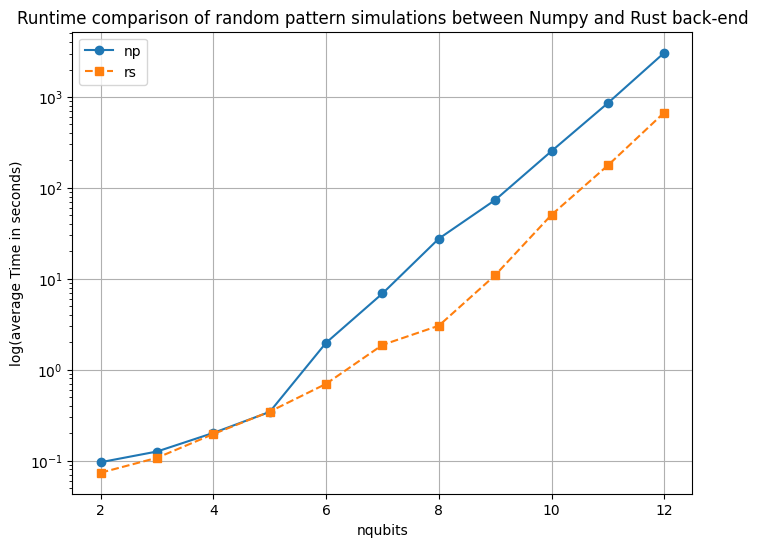

In [7]:
import matplotlib.pyplot as plt
import numpy as np

nsimulations = 10 # Number of simulations ran in the density matrix Graphix benchmark

# Extract values
x_values = sorted(times.keys())  # Sorted keys as x-axis
np_values = [float(times[x]['np']) / nsimulations for x in x_values] # Compute the mean runtime of the simulations
rs_values = [float(times[x]['rs']) / nsimulations for x in x_values]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, np_values, marker='o', linestyle='-', label='np')
plt.plot(x_values, rs_values, marker='s', linestyle='--', label='rs')

# Labels and title
plt.xlabel("nqubits")
plt.ylabel("log(average Time in seconds)")
plt.title("Runtime comparison of random pattern simulations between Numpy and Rust back-end")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Log scale for better visualization if values vary a lot

# Show plot
plt.show()